# Avalon Fingerprints for Molecular Property and Reaction Predictions

## 1. Abstract

This notebook utilises **Avalon Fingerprints** to model and predict:
1. **HOMO-LUMO Energy Gap of Organic Molecules**
2. **Reaction Yield for Buchwald-Hartwig Amination (C-N Cross-Coupling) Reactions**
3. **Catalytic Enantioselectivity of Thiol-Imine Reactions**

The **supervised learning methods** we will use two algorithms for **regression**:
1. **Random Forest Regressor**
2. **LightGBM Regressors**

<div align="center">
    <img src="../reports/figures/avalon-fingerprints-predictive-model.jpg", 
     alt="avalanon-fingerprints-predictive-model"/>
    <p style="text-align: center;">
      <b>Fig 1</b> Avalon Fingerprints for predictive modeling schematic. <b><sup>1</sup></b>
    </p>
</div>

The dataset **<sup>2</sup>** we will use consists of molecular SMILES strings and HOMO-LUMO energy gap (meV) of around 2,900 small organic molecules. It is from the work by *Sandford et al.* **<sup>3</sup>**, which the work in this notebook is based on.

In the work by *Sandfort et al.*, which utilises an **array of molecular fingerprints (multiple fingerprint features, MFF)**, as well as **individual molecular fingerprints (single fingerprint features, SFF)** to be used in **multivariate linear regression (MLR)** models to identify **linear free energy relationships** for **reaction prediction**.

The fingerprints *Sandfort et al.* use include:
* **Avalon Fingerprint** (3096 bits)
* **Atom-Pairs Fingerprint** (3096 bits)
* **Topological-Torsions Fingerprint** (3096 bits)
* **MACCS-keys Fingerprint** (167 bits)
* **RDKit Fingerprint**, radii 2, 4, 6, 8 (3096 bits)
* **RDKit linear Fingerprint**, radii 2, 4, 6, 8 (3096 bits)
* **RDKit layered Fingerprint**, radii 2, 4, 6, 8 (3096 bits)
* **Morgan-Circular Fingerprint**, radii 0, 2, 4, 6 (3096 bits)
* **Morgan-Circular Fingerprint with feature definitions**, radii 0, 2, 4, 6 (3096 bits)

Interestingly, in the results and discussion, *Sandfort et al.* report that for the prediction of HOMO-LUMO energy gaps, the **Avalon fingerprint is the most suitable single fingerprint** for training the machine learning model. 

However for C-N cross-coupling reaction yield predictions and prediction of enantioselectivities, there was **no clear single most suitable fingerprint**. 

Therefore, the **MFF model was used exclusively for all studies in the paper**.

<div align="center">
    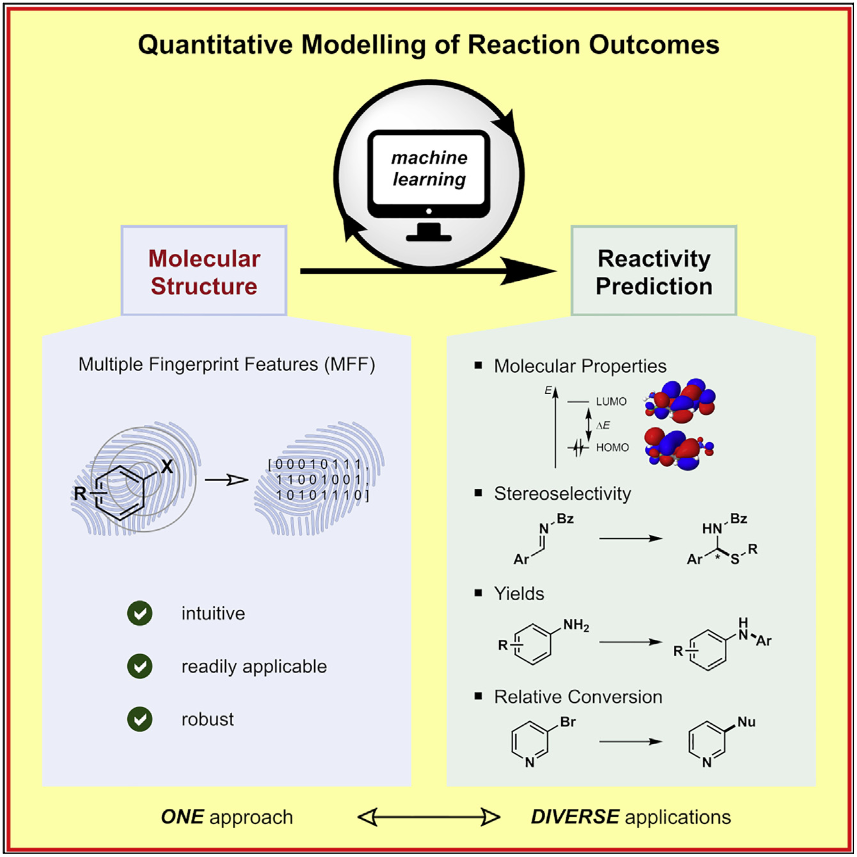
    <p style="text-align: center;">
      <b>Fig 2</b> A structure-based platform for predicting chemical reactivity by <i>Sandfort et al.</i> <b><sup>3</sup></b>
    </p>
</div>

In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
#-------------------------------------------------------
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from tqdm import tqdm
#-------------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split
#-------------------------------------------------------
from lightgbm import LGBMRegressor
from typing import List, Dict
#-------------------------------------------------------
os.environ['SUP_LEARN_PYTHON_DIR_PATH'] =  os.path.join(os.getcwd(), '../src')
os.environ['SUP_LEARN_DATA_DIR_PATH'] =  os.path.join(os.getcwd(), '../data')
sys.path.append(os.getenv('SUP_LEARN_PYTHON_DIR_PATH'))
sys.path.append(os.getenv('SUP_LEARN_DATA_DIR_PATH'))

from utils import avalon_fingerprints_utils

# 2. Reactivity Prediction: HOMO-LUMO Energy Gap of Organic Molecules

The HOMO-LUMO energy gap for the 2,900 small organic molecules in the dataset were obtained from **DFT calculations** (**Fig 3**). The small organic molecules in the dataset came from the *Sandfort et al.* group's inventory.

Current machine learning models for the **quantitative modelling of reaction outcomes based on DFT-calculate descriptors** require molecules that have **at least one structural motif, atom or functional group in common**. **<sup>3</sup>**

The goal of *Sandfort et al.* however, was to develop a model **applicable to a variety of organic chemical prediction problems**. HOMO-LUMO energy gap prediction is particularly useful in this context as it is a **property of the overall molecule**, and so a model trained on such data will represent and compare not only local substructures of a molecule, but also **global molecular characteristics**. **<sup>3</sup>**

<div align="center">
    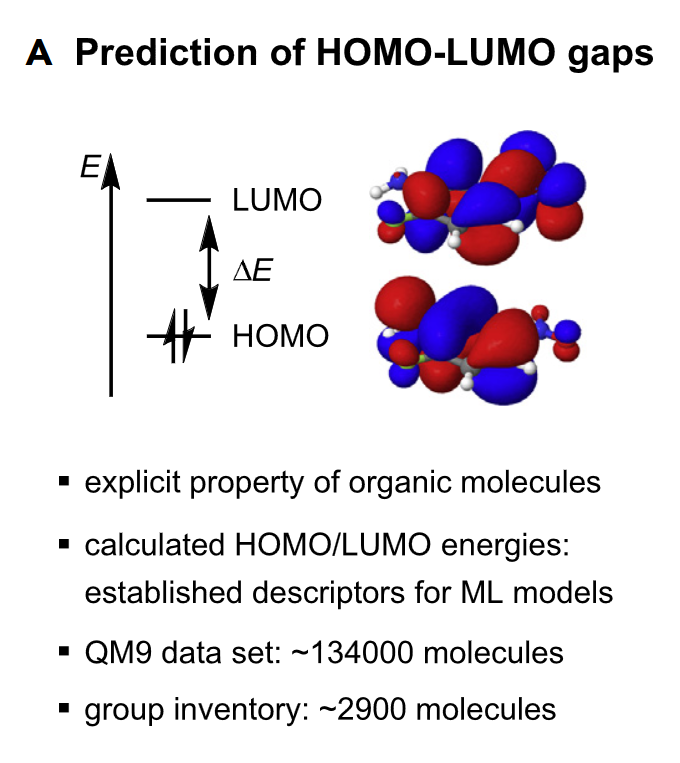
    <p style="text-align: center;">
      <b>Fig 3</b> Calculated HOMO-LUMO energy gaps as an explicit molecular property by <i>Sandfort et al.</i> <b><sup>3</sup></b> (2-Fluoro-5-nitroaniline calculated HOMO-LUMO geometries shown).
    </p>
</div>

## 2.1 Data Preparation

In [2]:
# Load data
homo_lumo_dataset: pd.DataFrame = pd.read_csv(
    os.path.join(
        os.getenv('SUP_LEARN_DATA_DIR_PATH'), 
        'raw/orbital-energies-input-data.csv'
    )
)

# Add 2D structure columnd
PandasTools.AddMoleculeColumnToFrame(
    homo_lumo_dataset,
    'SMILES',
    'Structure',
    includeFingerprints=True
)

# Generate Avalon fingerprints
homo_lumo_avalon_fpts: np.ndarray = avalon_fingerprints_utils.generate_avalon_fingerprints_from_mol(
    homo_lumo_dataset['Structure'],
    4096
)

# Insert into DataFrame. Each row represents a molecule's Avalon fingerprint and
# each column an individual bit
homo_lumo_ava_fpts_dataset: pd.DataFrame = pd.DataFrame(
    homo_lumo_avalon_fpts,
    columns=['Bit_{}'.format(bit) for bit in range(homo_lumo_avalon_fpts.shape[1])]
)

homo_lumo_ava_fpts_dataset.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2904/2904 [00:00<00:00, 3207.47it/s]


,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_4086,Bit_4087,Bit_4088,Bit_4089,Bit_4090,Bit_4091,Bit_4092,Bit_4093,Bit_4094,Bit_4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.2 Instantiate and Train Models

We will now **instantiate and train our models** on the Avalon fingerprint dataset.

### 2.2.1 LightGBM Regressor (`LGBMRegressor`)

LightGBM, which stands for **Light Gradient Boosting Machine**, is a **highly efficient and fast implementation of gradient boosting for decision tree algorithms**.
* **Gradient Boosting** is a powerful machine learning technique used for **both regression and classification tasks**.
* **It builds an ensemble of trees** in a **sequential manner**, where each new tree is **trained to correct the errors of the previous trees**.
* This is in contrast to **bagging-based algorithms** such as **Random Forest**, where the trees in the ensemble are **built independently and combined**.
* It **combines the predictions of multiple weaker learners** to create a **strong learner predictive model**.
* Gradient boosting uses **gradient descent to minimise loss function loss** (*c.f.* `intro_to_supervised_learning.ipynb`). Each new tree is **fit on the negative gradient of the loss function** with respect to the **predictions of the previously built ensemble of trees**.

LightGBM has the following key characteristics:
1. **Speed and Efficiency**: LightGBM is **optimised for performance and memory usage**, making it **much faster than other gradient boosting implementations**.
2. **Support for large datasets**: LightGBM can **handle large-scale data** with **millions of instances and features** efficiently.
3. **Accuracy**: It provides **high accuracy** due to the implementation of advanced features like **leaf-wise tree growth** (uses the leaf with the **maximum reduction in loss to be split next**.

The **`LGBMRegressor`** class in the **LightGBM library** is **designed specifically for regression tasks**. It inherits from LightGBM's core functionalities and allows for the building of **powerful regression models**.

In [3]:
# Instantiate the `LGBMRegressor` model. The `n_estimators` argument specifies the number of boosting
# iteratinos (i.e. the number of trees in the model). The `random_state` argument sets the seed for the
# random number generator, ensuring the results are reproducible (i.e. that the same random sequences are
# generated each time the code is run)
lgbm_regressor: LGBMRegressor = LGBMRegressor(n_estimators=800, random_state=42)

### 2.2.2 Random Forest Regressor (`RandomForestRegressor`)

The class `RandomForestRegressor` is a **popular ensemble supervised learning method** from the **scikit-learn library**. It is used for **regression tasks** and, like LightGBM regressor, **combines the predictions of multiple weaker learners** to create a **strong learner predictive model**.

However, it differs from LightGBM regressor in that it utilises the technique called **bagging** where the **predictions of the individual trees are aggregated through averaging to give a final, stronger prediction**.

In [4]:
# Instantiate the `RandomForestRegressor`model. The `random_state` argument sets the seed for the random 
# number generator, ensuring the results are reproducible 
rf_regressor: RandomForestRegressor = RandomForestRegressor(random_state=42)

## 2.3 10-Fold Cross-Validation of LightGBM Regressor Model using Avalon Fingerprints & HOMO-LUMO Energy Gap Dataset

**Cross-validation** is a statistical method used to **evaluate the performance of a machine learning model** by **paritioning the original dataset** into a training set to train the model and a test set to evaluate it. 

The cross-validation method we will use is `ShuffleSplit` which **randomly shuffles** the data before **splitting it into a specified number of splits**. In this case, we will split it 10 times, hence a **10-fold cross-validation**.

Cross-validation provides a **more reliable esimate of model performance** than a **single train-test split**.

In [5]:
# Start timer to calculate total execution time
start_time: float = time.time()

# Create a cross-validator that randomly shuffles and splits data into training and test sets
# `n_splits=10` specifies that 10 splits should be created. This is the 10-fold cross-validation
# `test_size=0.3` specifies that 30% of the data should be used as the test set for each split
# `randdm_state=42` specifies the random seed to ensure reproducibility
homo_lumo_cross_validator: ShuffleSplit = ShuffleSplit(
    n_splits=10, 
    test_size=0.3, 
    random_state=42
)

# Define scoring metrics. 
# Metric `r2` is the coefficient of determination, which measures the proportion of variance explained by the model
# Metric `neg_mean_absolute_error` is the negative mean absolute error, measuring the average absolute errors
# between the predicted and actual values
homo_lumo_scoring_metrics: List[str] = ['r2', 'neg_mean_absolute_error']

# Cross-validation execution.
homo_lumo_cross_validation_scores: Dict = cross_validate(
    lgbm_regressor, # The LightGBM model to evaluate
    homo_lumo_ava_fpts_dataset, # The feature matrix
    homo_lumo_dataset.Energygap, # The target variable
    scoring=homo_lumo_scoring_metrics, # The list of metrics to evaluate
    cv=homo_lumo_cross_validator # The cross-validator
)

print(homo_lumo_cross_validation_scores)

end_time: float = time.time()
execution_time: float = end_time - start_time
print(
    '\n HOMO-LUMO Energy Gap Model Cross-Validation Execution Time: ', 
    round(execution_time/60, 2), 'min'
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 2032, number of used features: 1024
[LightGBM] [Info] Start training from score 191.052642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2062
[LightGBM] [Info] Number of data points in the train set: 2032, number of used features: 1031
[LightGBM] [Info] Start training from score 190.942365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [6]:
# Output coefficient of determination (R²) of LightGBM regressor 10-fold cross-validation
homo_lumo_cross_validation_scores['test_r2']

array([0.91044654, 0.90800796, 0.91153183, 0.92018218, 0.9045963 ,
       0.89865031, 0.90671041, 0.90788038, 0.89827042, 0.91485459])

In [7]:
# Output mean absolute error (MAE) of LightGBM regressor 10-fold cross-validation 
# (negative of negative  mean absolute error)
-homo_lumo_cross_validation_scores['test_neg_mean_absolute_error']

array([5.79133628, 5.82072238, 5.86919926, 5.52286442, 6.21463951,
       6.16613145, 5.97132058, 6.12992087, 5.94971449, 5.76417806])

In [8]:
# Output mean values of R² and MAE for 10-fold cross-validation of LightGBM regressor
print(
    'HOMO-LUMO Energy Gap Model Cross-Validation R²: ', 
    round(np.mean(homo_lumo_cross_validation_scores['test_r2']), 2), 
    '\n'
)

print(
    'HOMO-LUMO Energy Gap Model Cross-Validation Mean Absolute Error (MAE): ', 
    round(np.mean(-homo_lumo_cross_validation_scores['test_neg_mean_absolute_error']), 2)
)

HOMO-LUMO Energy Gap Model Cross-Validation R²:  0.91 

HOMO-LUMO Energy Gap Model Cross-Validation Mean Absolute Error (MAE):  5.92


## 2.4 Split Avalon Fingerprints and HOMO-LUMO Energy Gap Dataset Into Training Data & Testing Data to Train & Test LightGBM Regressor Model

In [9]:
# Split data into training and test sets using `train_test_split()` function
# `homo_lumo_model_x_train_data` and `homo_lumo_model_x_test_data` are the feature matrices 
# for training and testing (Avalon fingerprints)
# `homo_lumo_model_y_train_data` and `homo_lumo_model_y_test_data` are the target vectors for 
# training and testing (HOMO-LUMO energy gap)
(homo_lumo_model_x_train_data, homo_lumo_model_x_test_data, 
 homo_lumo_model_y_train_data, homo_lumo_model_y_test_data) = train_test_split(
    homo_lumo_ava_fpts_dataset, # The feature matrix (Avalon fingerprints)
    homo_lumo_dataset.Energygap, # The target variable (observed HOMO-LUMO energy gap)
    test_size=0.3, # 30% of the data is reserved for testing, and 70% is used for training
    random_state=42 # Random number generator seed
)

# LightGBM model training
ava_homo_lumo_lgbm_model: LGBMRegressor = lgbm_regressor.fit(
    homo_lumo_model_x_train_data, # Training feature matrix (Avalon fingerprints)
    homo_lumo_model_y_train_data # Training target vector (HOMO-LUMO energy gap)
)

# Test trained LightGBM model using testing feature matrix (Avalon fingerprints)
# Outputs a predicted target vector (predicted HOMO-LUMO energy gap)
homo_lumo_lgbm_model_predict: np.array = ava_homo_lumo_lgbm_model.predict(
    homo_lumo_model_x_test_data
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 2032, number of used features: 1024
[LightGBM] [Info] Start training from score 191.052642


In [10]:
# Measure model performance with Pearson correlation coefficient (R) between actual and predicted HOMO-LUMO gap values
# Slice correlation between predicted labels and actual labels from correlation matrix
homo_lumo_model_predict_r: np.float64 = np.corrcoef(
    homo_lumo_model_y_test_data, 
    homo_lumo_lgbm_model_predict
)[0, 1]

print(
    '\n LightGBM Regressor HOMO-LUMO Energy Gap Prediction R: ', 
    round(homo_lumo_model_predict_r, 2)
)


 LightGBM Regressor HOMO-LUMO Energy Gap Prediction R:  0.95


In [11]:
# Measure model performance with coefficient of determination (R²) score between actual and predicted HOMO-LUMO gap values
homo_lumo_model_predict_r2: float = r2_score(
    homo_lumo_model_y_test_data, 
    homo_lumo_lgbm_model_predict
)
print(
    '\n LightGBM Regressor HOMO-LUMO Energy Gap Prediction R²: ', 
    round(homo_lumo_model_predict_r2, 2)
)


 LightGBM Regressor HOMO-LUMO Energy Gap Prediction R²:  0.91


In [12]:
# Measure model performance by calculating mean average error (MAE) between actual and predicted HOMO-LUMO gap values
homo_lumo_model_predict_mae: np.float64 = mean_absolute_error(
    homo_lumo_model_y_test_data, 
    homo_lumo_lgbm_model_predict
)

print(
    '\n LightGBM Regressor HOMO-LUMO Energy Gap Prediction MAE: ', 
    round(homo_lumo_model_predict_mae, 2)
)


 LightGBM Regressor HOMO-LUMO Energy Gap Prediction MAE:  5.79


## 2.5 Parity Plot for Model HOMO-LUMO Energy Gapy Prediction From Avalon Fingerprints

In [13]:
# LightGBM Regressor HOMO-LUMO Energy Gap Prediction Parity Plot
sns.regplot(
    x=homo_lumo_lgbm_model_predict, 
    y=homo_lumo_model_y_test_data,
    line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7}
)
plt.xlabel(r"Predicted $\Delta E$ (kcal/mol) $\hat{y}$")
plt.ylabel(r"Observed $\Delta E$ (kcal/mol) $y$")
plt.title("Avalon Fingerprint HOMO-LUMO Energy Gap Prediction Parity Plot")
plt.grid(alpha=0.2)

homo_lumo_predict_label_text: str = (
    f"R = {homo_lumo_model_predict_r:.2f}\n"
    f"R² = {homo_lumo_model_predict_r2:.2f}\n"
    f"MAE (kcal/mol) = {homo_lumo_model_predict_mae:.2f}"
)

plt.text(0.05, 0.95, homo_lumo_predict_label_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(facecolor='white', boxstyle='round,pad=0.5'))

plt.savefig(
    os.path.join(
        os.getenv('SUP_LEARN_DATA_DIR_PATH'),
        'analysis/plots/avalon-homo-lumo-energy-gap-parity-plot.png'
    )
)

plt.close()

<div align="center">
    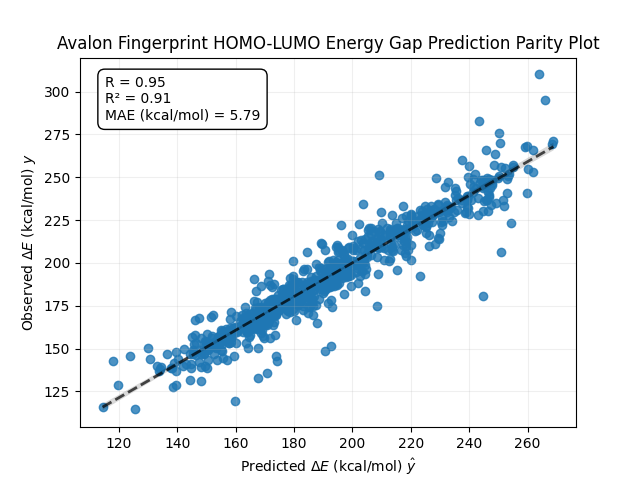
    <p style="text-align: center;">
        <b>Fig 4</b> Parity plot for LightGMB regressor HOMO-LUMO energy gap prediction from Avalon molecular fingerprints
    </p>
</div>

In **Fig 5**, we can see a comparison from the model performance evaluation in the paper by *Sandford et al.* **<sup>3</sup>** We are using the research group's inventory dataset. 

Although *Sandford et al.* is using an **MFF model** (i.e. more than one molecular fingerprint), the $R^2$ and mean absolute error of our cross-validation **is comparable to theirs**.

<div align="center">
    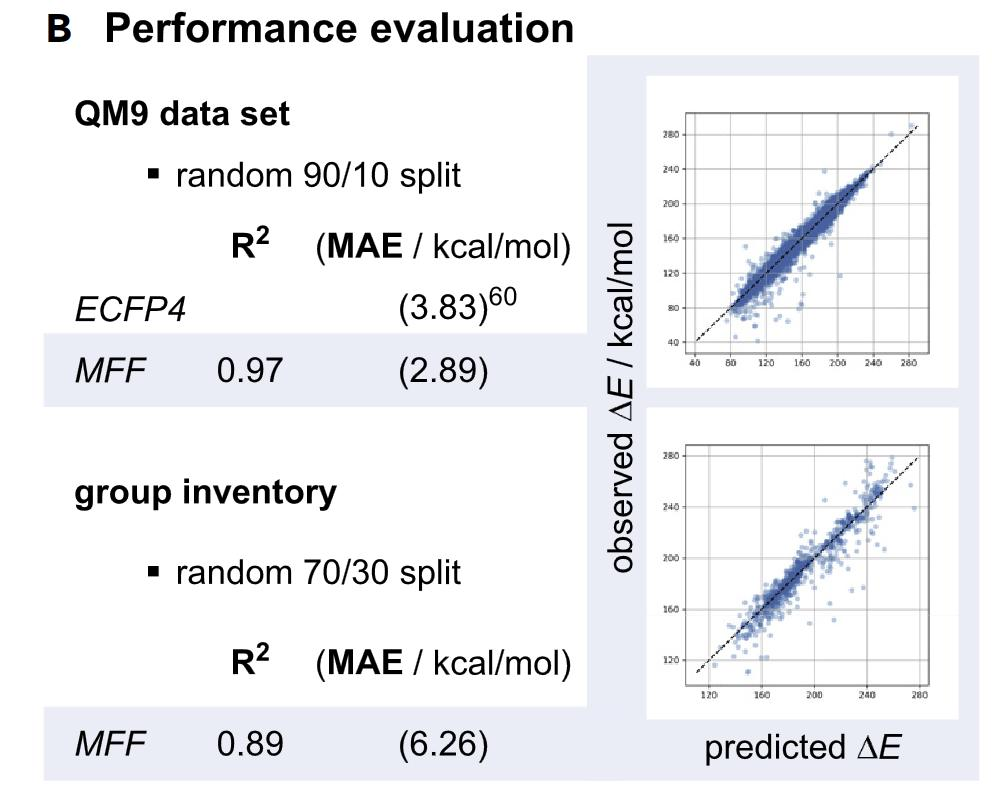
    <p style="text-align: center;">
      <b>Fig 5</b> Performance evaluation of the MFF model on the QM9 dataset and the research group's inventory dataset by <i>Sandfort et al.</i> <b><sup>3</sup></b>
    </p>
</div>

# 3. Reactivity Prediction: Buchwald-Hartwig Amination (C-N Cross-Coupling) Reaction Yield

In comparison to **stereoselectivities/enantioselectivities**, the **quantitative prediction of yields** can be **more demanding** as they are **influenced by many parameters** and **do not rely on a single elementary step alone**. **<sup>3</sup>**

In their paper, the *Sandford et al.* group cite the pioneering work of *Ahneman et al.* **<sup>4</sup>**  who were able to predict the reaction yields of C-N cross coupling reactions by using a dataset of more than 4,000 reactions. **<sup>3</sup>**

*Ahneman et al.* collected the training data via **high-throughput experiementation** using **combinatorial synthesis of four reaction componenets**. 

The total number of reaction components was:
* 15 aryl halides
* 23 isoxazole additives
* 4 ligands
* 3 bases

This brings the total number of reactions evaluated to **4140 ($15 \times 3 \times 23 \times 4$)**.

The high-throughput experimenation involved **three 1536 well plates**, with **each well accomodating one reaction**. This would allow for a total of **4608 simulataneous reactions ($3 \times 1536$)**, with **yields determined via UPLC with di-*tert*-butyldiphenyl as an internal standard**.

Not all of the evaluated reactions were used in the dataset. These included:
1,. **Control reactions**.
2. Reactions where the **isoxazole additive starting material overlapped with nearby peaks in UPLC**, making the **yield difficult to quanitify**.

After these reactions had been removed, this brought the total number of reactions in the dataset to **3,960**. These were then used in the training of the model.

<div align="center">
    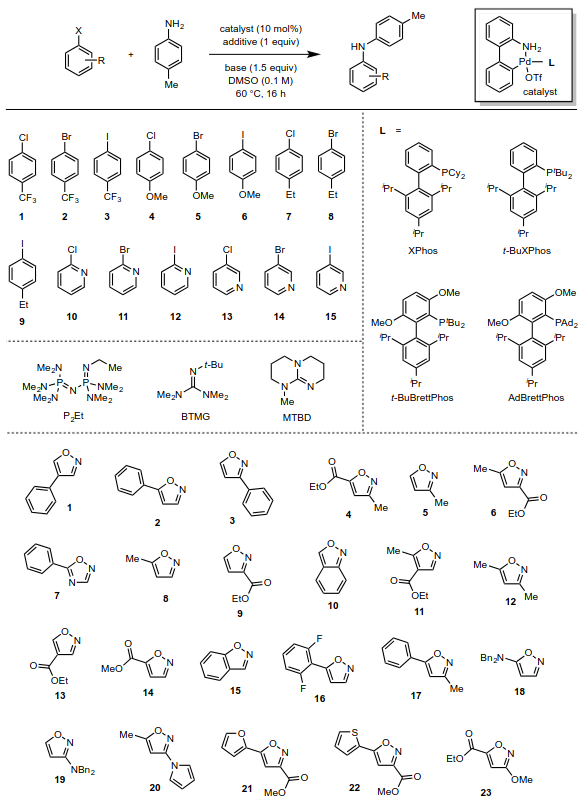
    <p style="text-align: center;">
        <b>Fig 6</b> <i>Ahneman et al.</i> C-N cross-couping reaction components <b><sup>4</sup></b>
    </p>
</div>

For the **features of the models**, *Ahneman et al.* used **B3LYP/6-31G\* DFT calculations** to **calculate the following descriptors**:
* Electrostatic charge
* NMR shift
* Molecular volume
* Surface area
* Ovality
* Molecular weight
* $E_{HOMO}$
* $E_{LUMO}$
* Electronegativity
* Hardness
* Dipole moment

In total, **120 descriptors were calculated** for the components of the C-N cross-coupling reactions:
* Additive descriptors (19)
* Aryl halide descriptors (27)
* Base descriptors (10)
* Ligand descriptors (64)

The model training was carried out using these descriptors, with a 70/30 split of training and test data. Various machine learning algorithms were used, and their parity plots were compared (**Fig 7**).

<div align="center">
    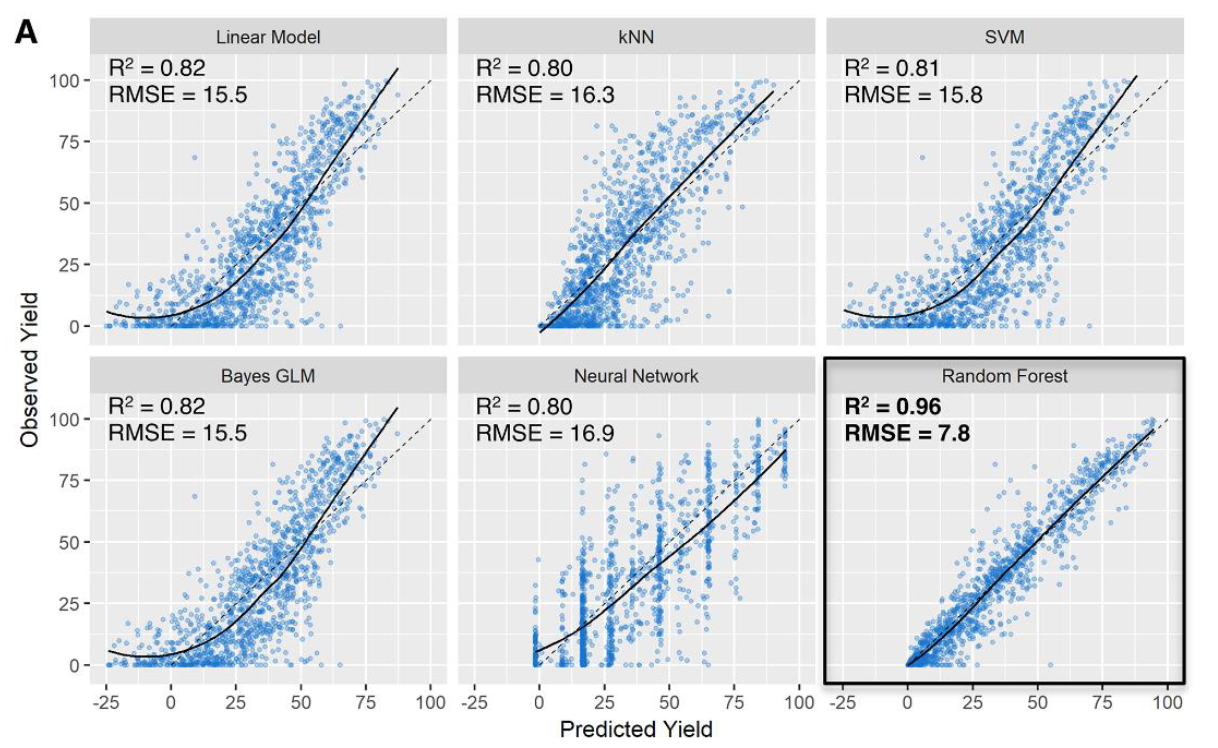
    <p style="text-align: center;">
        <b>Fig 7</b> <i>Ahneman et al.</i> Parity plots for various machine learning algorithms for C-N cross-couping reaction yield prediction <b><sup>4</sup></b>
    </p>
</div>

*Sandford et al.* used the dataset of *Ahneman et al.* to train and test both their MFF and SFF models for to compare their models performance against those in **Fig 6**.

We will utilise this same dataset to implement a **LightGBM regressor model** with our **Avalon fingerprint descriptors**. We will then compare our model's prediction with that of *Ahneman et al.*

## 3.1 Data Preparation

In [14]:
# Load data
buchwald_amin_yield_dataset: pd.DataFrame = pd.read_csv(
    os.path.join(
        os.getenv('SUP_LEARN_DATA_DIR_PATH'), 
        'raw/buchwald_yield_data.csv'
    )
)

# Output C-N cross-coupling reaction yields
buchwald_amin_yield_dataset.Output

0       70.410458
1       11.064457
2       10.223550
3       20.083383
4        0.492663
          ...    
3950     4.344677
3951    47.156275
3952     0.701552
3953    15.561565
3954    73.739939
Name: Output, Length: 3955, dtype: float64

In [15]:
# Calculate Avalon fingerprints for all four cross-coupling components
ligand_ava_fpts: ExplicitBitVect = avalon_fingerprints_utils.generate_avalon_fingerprints_from_smiles(
    buchwald_amin_yield_dataset['Ligand'],
    2048
)

additive_ava_fpts: ExplicitBitVect = avalon_fingerprints_utils.generate_avalon_fingerprints_from_smiles(
    buchwald_amin_yield_dataset['Additive'],
    1024
)

base_ava_fpts: ExplicitBitVect = avalon_fingerprints_utils.generate_avalon_fingerprints_from_smiles(
    buchwald_amin_yield_dataset['Base'],
    1024
)

aryl_halide_ava_fpts: ExplicitBitVect = avalon_fingerprints_utils.generate_avalon_fingerprints_from_smiles(
    buchwald_amin_yield_dataset['Aryl halide'],
    1024
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:00<00:00, 6658.35it/s]


In [16]:
# Concatenate Avalon fingerprints of the four cross-coupling components
# `axis=1` argument concatenates the arrays column-wise. This gives a new
# array where each row represents a molecule and each column represents a
# bit from one of the four fingerprint vectors
buchwald_amin_ava_fpts = np.concatenate(
    [
        ligand_ava_fpts,
        additive_ava_fpts,
        base_ava_fpts,
        aryl_halide_ava_fpts
    ],
    axis=1
)

# Insert into DataFrame. Each row represents a molecule's Avalon fingerprint and
# each column an individual bit
buchwald_amin_ava_fpts_dataset: pd.DataFrame = pd.DataFrame(
    buchwald_amin_ava_fpts,
    columns=['Col_A_{}'.format(bit + 1) for bit in range(buchwald_amin_ava_fpts.shape[1])]
)

buchwald_amin_ava_fpts_dataset

,Col_A_1,Col_A_2,Col_A_3,Col_A_4,Col_A_5,Col_A_6,Col_A_7,Col_A_8,Col_A_9,Col_A_10,...,Col_A_5111,Col_A_5112,Col_A_5113,Col_A_5114,Col_A_5115,Col_A_5116,Col_A_5117,Col_A_5118,Col_A_5119,Col_A_5120
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## 3.2 10-Fold Cross-Validation of LightGBM Regressor Model using Avalon Fingerprints of Buchwald-Hartwig Cross-Coupling Components and Cross-Coupling Yields

In [17]:
# Start timer to calculate total execution time
start_time: float = time.time()

# Create a cross-validator that randomly shuffles and splits data into training and test sets
# `n_splits=10` specifies that 10 splits should be created. This is the 10-fold cross-validation
# `test_size=0.3` specifies that 30% of the data should be used as the test set for each split
# `randdm_state=42` specifies the random seed to ensure reproducibility
cn_coupling_yields_cross_validator: ShuffleSplit = ShuffleSplit(
    n_splits=10, 
    test_size=0.3, 
    random_state=42
)

# Define scoring metrics. 
# Metric `r2` is the coefficient of determination, which measures the proportion of variance explained by the model
# Metric `neg_root_mean_squared_error` is the negative root mean squared error, a measure of the differences 
# between the predicted and actual values
cn_coupling_yields_scoring_metrics: List[str] = ['r2', 'neg_root_mean_squared_error']

# LightGBM regressor cross-validation execution.
cn_coupling_yields_cross_validation_scores: Dict = cross_validate(
    lgbm_regressor, # The LightGBM model to evaluate
    buchwald_amin_ava_fpts_dataset, # The feature matrix
    buchwald_amin_yield_dataset.Output, # The target variable (observed C-N cross-coupling yields)
    scoring=cn_coupling_yields_scoring_metrics, # The list of metrics to evaluate
    cv=cn_coupling_yields_cross_validator # The cross-validator
)

print(cn_coupling_yields_cross_validation_scores)

end_time: float = time.time()
execution_time: float = end_time - start_time
print(
    '\n C-N Cross-Coupling Model Cross-Validation Execution Time: ', 
    round(execution_time/60, 2), 'min'
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 2768, number of used features: 904
[LightGBM] [Info] Start training from score 33.142928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 2768, number of used features: 904
[LightGBM] [Info] Start training from score 33.110559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [18]:
# Output mean values of R² and MAE for 10-fold cross-validation of LightGBM regressor
print(
    'C-N Cross-Coupling Model Cross-Validation Cross-Validation R²: ', 
    round(np.mean(cn_coupling_yields_cross_validation_scores['test_r2']), 2), 
    '\n'
)

print(
    'C-N Cross-Coupling Model Cross-Validation Mean Absolute Error: ', 
    round(
        np.mean(-cn_coupling_yields_cross_validation_scores['test_neg_root_mean_squared_error']), 
        2
    )
)

C-N Cross-Coupling Model Cross-Validation Cross-Validation R²:  0.95 

C-N Cross-Coupling Model Cross-Validation Mean Absolute Error:  6.06


## 3.3 Split Avalon Fingerprints and Cross-Coupling Yield Dataset Into Training Data & Testing Data to Train & Test LightGBM Regressor Model

In [19]:
# Split data into training and test sets using `train_test_split()` function
# `cn_coupling_avalon_fpts_x_train` and `cn_coupling_avalon_fpts_x_test` are the feature 
# matrices for training and testing (Avalon fingerprints).
# `cn_coupling_yields_y_train` and `cn_coupling_yields_y_test` are the target 
# vectors for training and testing (C-N cross-coupling yields)
(cn_coupling_avalon_fpts_x_train, cn_coupling_avalon_fpts_x_test, 
 cn_coupling_yields_y_train, cn_coupling_yields_y_test) = train_test_split(
    buchwald_amin_ava_fpts_dataset, # The feature matrix (Avalon fingerprints)
    buchwald_amin_yield_dataset.Output, # The target variable (observed C-N cross-coupling yield)
    test_size=0.3, # 30% of the data is reserved for testing, and 70% is used for training
    random_state=42 # Random number generator seed
)

# LightGBM model training
ava_cn_coupling_yields_lgbm_model: LGBMRegressor = lgbm_regressor.fit(
    cn_coupling_avalon_fpts_x_train, # Training feature matrix (Avalon fingerprints)
    cn_coupling_yields_y_train # Training target vector (C-N cross-coupling yields)
)

# Test trained LightGBM model using testing feature matrix (Avalon fingerprints)
# Outputs a predicted target vector (predicted C-N cross-coupling yields)
cn_coupling_yields_model_predict: np.array = ava_cn_coupling_yields_lgbm_model.predict(
    cn_coupling_avalon_fpts_x_test
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 2768, number of used features: 904
[LightGBM] [Info] Start training from score 33.142928


In [20]:
# Measure model performance with Pearson correlation coefficient (R) between actual and predicted C-N cross-coupling yields
# Slice correlation between predicted labels and actual labels from correlation matrix
cn_coupling_yields_predict_r: np.float64 = np.corrcoef(
    cn_coupling_yields_y_test,
    cn_coupling_yields_model_predict
)[0, 1]

print(
    '\n LightGBM Regressor C-N Cross-Coupling Reaction Yield Prediction R: ', 
    round(cn_coupling_yields_predict_r, 2)
)


 LightGBM Regressor C-N Cross-Coupling Reaction Yield Prediction R:  0.98


In [21]:
# Measure model performance with coefficient of determination (R²) score between actual and predicted C-N cross-coupling yields
cn_coupling_yields_predict_r2: float = r2_score(
    cn_coupling_yields_y_test,
    cn_coupling_yields_model_predict
)
print(
    '\n LightGBM Regressor C-N Cross-Coupling Reaction Yield Prediction R²: ', 
    round(cn_coupling_yields_predict_r2, 2)
)


 LightGBM Regressor C-N Cross-Coupling Reaction Yield Prediction R²:  0.95


In [22]:
# Measure model performance by calculating mean average error (MAE) between actual and predicted C-N cross-coupling yields
cn_coupling_yields_predict_mae: np.float64 = mean_absolute_error(
    cn_coupling_yields_y_test, 
    cn_coupling_yields_model_predict
)

print(
    '\n LightGBM Regressor C-N Cross-Coupling Reaction Yield Prediction MAE: ', 
    round(cn_coupling_yields_predict_mae, 2)
)


 LightGBM Regressor C-N Cross-Coupling Reaction Yield Prediction MAE:  4.11


In [23]:
# LightGBM Regressor C-N Cross-Coupling Reaction Yield Prediction Parity Plot
sns.regplot(
    x=cn_coupling_yields_model_predict, 
    y=cn_coupling_yields_y_test,
    line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7}
)
plt.xlim(0, 100)
plt.ylim(0,100)
plt.xlabel(r"Predicted C-N Cross-Coupling Yield (%) $\hat{y}$")
plt.ylabel(r"Observed C-N Cross-Coupling Yield (%) $y$")
plt.title("Avalon Fingerprint C-N Cross-Coupling Yield Prediction Parity Plot")
plt.grid(alpha=0.2)

cn_coupling_yields_predict_label_text: str = (
    f"R = {cn_coupling_yields_predict_r:.2f}\n"
    f"R² = {cn_coupling_yields_predict_r2:.2f}\n"
    f"MAE (kcal/mol) = {cn_coupling_yields_predict_mae:.2f}"
)

plt.text(0.05, 0.95, cn_coupling_yields_predict_label_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', 
                                                         boxstyle='round,pad=0.5'))

plt.savefig(
    os.path.join(
        os.getenv('SUP_LEARN_DATA_DIR_PATH'),
        'analysis/plots/avalon-cn-couping-yield-parity-plot.png'
    )
)

plt.close()

<div align="center">
    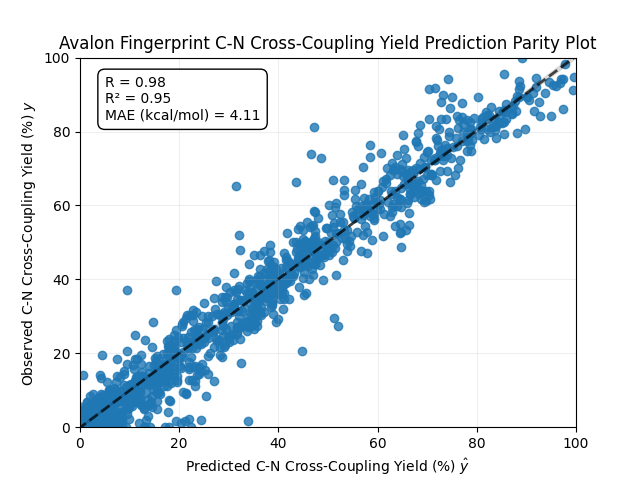
    <p style="text-align: center;">
        <b>Fig 8</b> Parity plot for LightGMB regressor C-N cross-coupling yield prediction from Avalon fingerprints
    </p>
</div>

In **Fig 9**, we can see a performance evaluation comparison of the MFF model by *Sandford et al.* **<sup>3</sup>** and the Random Forest model by *Ahneman et al.* (labelled as *Doyle*) **<sup>4</sup>**. Both models used a random 70/30 split of the *Ahneman et al.* dataset.

Our LightGBM regressor model cross-validation has a comparable $R^2$ and root mean squared error.

<div align="center">
    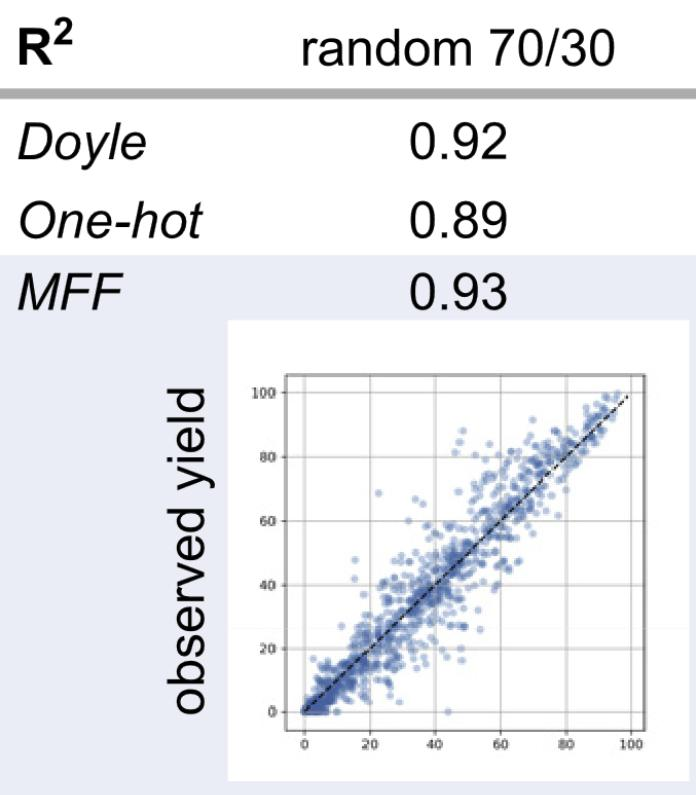
    <p style="text-align: center;">
      <b>Fig 9</b> Performance evaluation of the <i>Sandford et al.</i> MFF model on predicting C-N cross-coupling reaction yields. <b><sup>3</sup></b>
    </p>
</div>

# 4. Reactivity Prediction: Catalytic Enantioselectivity of Thiol-Imine Reactions

The **prediction of stereoselectivities/enantioselectivities in asymmetric catalysis** has been of great interest to the field of chemistry and has been the **focus of many multivariate linear regression models**. **<sup>3</sup>** **<sup>5</sup>** **<sup>6</sup>**

In their paper, the *Sandford et al.* group cite the work of *Zahrt et al.*, **<sup>7</sup>** who report a machine learning-based approach for the prediction of **chiral phosphoric acid-catalysed thiol addition to *N*-acylimines**.

For this **asymmetric *N,S*-acetal formation model reaction**, the training set included **combinatorial variations** of:
* 43 chrial phosphoric acid (CPA) catalysts
* 5 *N*-acyl imines
* 5 thiols

This brings the total number of reactions evaluated to **1,075 ($43 \times 5 \times 5$)**. To represent the CPA catalysts, a **steric-based molecular descriptor** called the **average steric occupancy (ASO)** was calculated. This ASO descriptor was based on **DFT-computed 3D representations of the entire conformer ensemble for each CPA catalyst**.

The protocol for **generating these CPA catalyst ASO descriptors** is illustrated in **Fig 8**. This included:
1. A **conformer distribution** for each CPA catalyst in the *in silico* library was obtained.
2. For each catalyst, the conformers were **aligned and individually placed on identical grids**.
3. If a given **grid point** on the grid was within the **van der Waals radius of an atom**, it was given a value of $1$; else, it was assigned a value of $0$.
4. This process was repeated for *n* conformers, and upon completion each grid point had a **cumulative value ranging from 0 to *n***.
5. These were then **normalised** by **dividing by *n***, such that **all grid points had a value between 0 and 1**

<div align="center">
    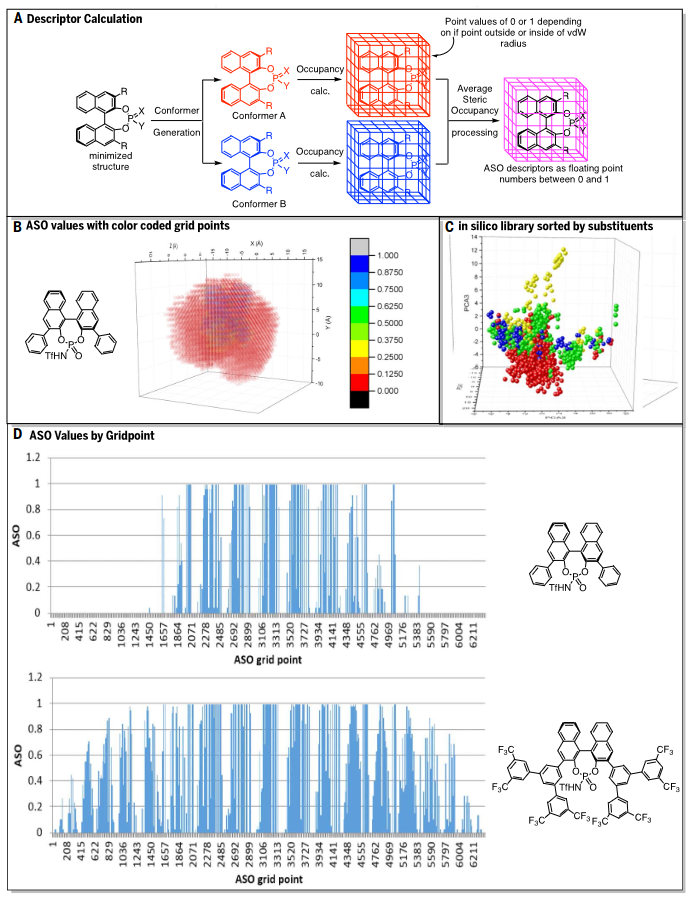
    <p style="text-align: center;">
      <b>Fig 10</b> <i>Zahrt et al.</i> <b>Generation of ASO descriptors</b>. <b>(A)</b> Pictorial description of ASO calculation. <b>(B)</b> ASO grid points occupied by no catalyst conformer atoms have values of 0 (red). Grid points occupied by atoms of all conformers have a value of 1 (blue). Flexible substituents lie between 0 and 1 (green and yellow regions). <b>(C)</b> ASO discrimination of 3,3′-substituent groups: ortho-substituted arenes
(red), fused-ring substituents (blue), 3,5-disubstituted arenes (yellow), and
all other groups (green). <b>(D)</b> Bar graph representation of ASO descriptors for two different types of Brønsted acid catalysts (CPA catalysts) <b><sup>7</sup></b>
    </p>
</div>

*Zahrt et al.* also derived **electronic descriptors** from the **perturbation that the CPA catalysts' substituents exerted on the electrostatic potential map of a quaternary ammonium ion**.

These **substituent-based electronic descriptors** were then used in combination with the ASO descriptors to train the machine learning model to **predict enantioselectivity**. In total, this amounted to **16,384 features per catalyst**. 

Enantioselectivity was measured using **$\Delta \Delta G$ in kcal/mol**:
* $\Delta G$ is the **change in Gibbs free energy for a process or reaction**
* $\Delta \Delta G$ refers to the **difference of in the $\Delta G$ of two competing processes or reactions**, often used to describe the **selectivity or preference between two pathways**.

In the context of chiral catalyst enantioselectivity, a **negative $\Delta \Delta G$** would indicate that **one enantiomer is preferentially formed**, with a **positive $\Delta \Delta G$** indicating that the **other enantiomer is preferentially formed**. For example:

$$ \Delta \Delta G = \Delta G_B - \Delta G_A$$

if:
* $\Delta G_A = -10 kcal/mol$
* $\Delta G_A = -12 kcal/mol$

Then:
$$ \Delta \Delta G = -12 - (-10) = -2 kcal/mol$$

The negative $\Delta \Delta G$ value suggests that the **formation of enantiomer B is energetically more favourable than the formation of enantiomer A** by **2 kcal/mol**.

<div align="center">
    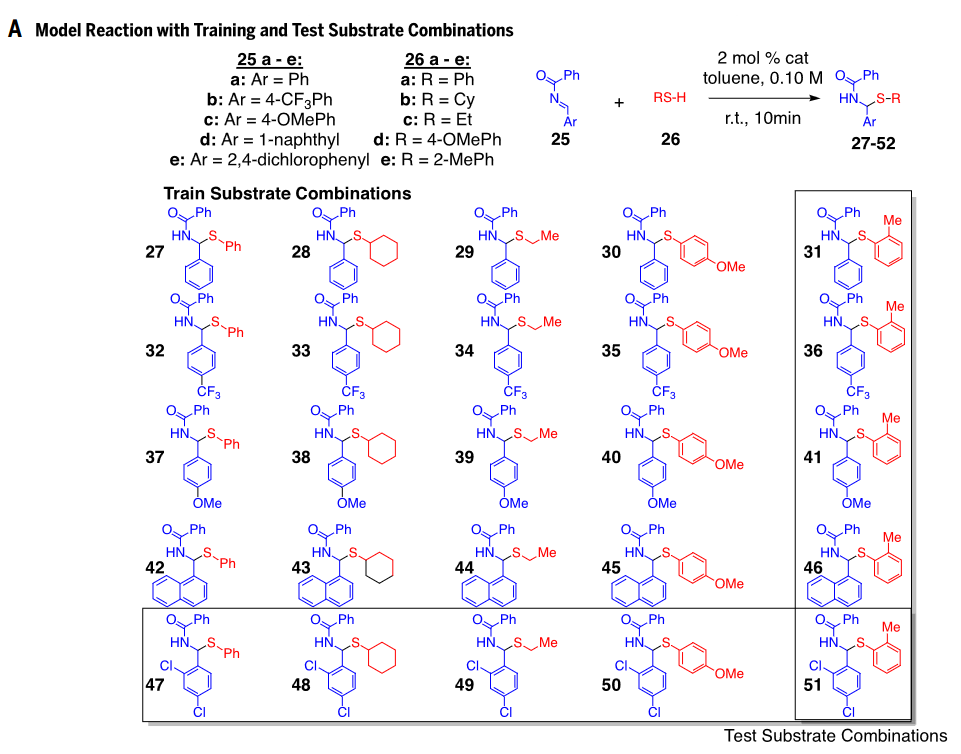
    <p style="text-align: center;">
      <b>Fig 11</b> The enantioselective formation of <i>N,S</i>-acetals developed by <i>Antila et al.</i> <b><sup>8</sup></b> chosen by <i>Zahrt et al.</i> to evaluate the training set. <b><sup>7</sup></b>
    </p>
</div>

To **validate the ASO and electronic descriptors**, as well as the **training set selection protocol**, the training set was evaluated on a **previously optimised reaction** developed by *Antila et al.*; the **enantioselective formation of *N,S*-acetals** (**Fig 9**). It was chosen as it is **high yielding**, **highly reproducible** and can be **performed under ait at room temperature**, thus **facilitating rapid screening**. **<sup>3</sup>**

*Zahrt et al.* found that a **distance-based support vector machine (SVM) algorithm** performed best with a **random 600/475 split of training data and test data**. This gave an **MAE = 0.152 kcal/mol**, averaged over **ten random dataset splits/divisions**.

When comparing their MFF model to the model of *Zahrt et al.* with a **similar random splitting of the dataset**, *Sandfort et al.* found that **their model performed with slightly higher accuracy by using a random forest algorithm**. This gave an **MAE = 0.144 kcal/mol**, averaged over **ten random dataset splits/divisions**.

Regarding the **division of the dataset**, both *Zahrt et al.*  and *Sandfort et al.* divided the data into:
1. A **common training set**
2. A **test set for substrates (sub)**
3. A **test set for catalysts (cat)**
4. A **test set for both substrates & catalysts (sub-cat)**

We will utilise this same dataset with the same data split protocol to implement a **Random Forest regressor model** with our **Avalon fingerprint descriptors**. We will then compare our model's prediction with that of *Zahrt et al.* and *Sandfort et al.*

<div align="center">
    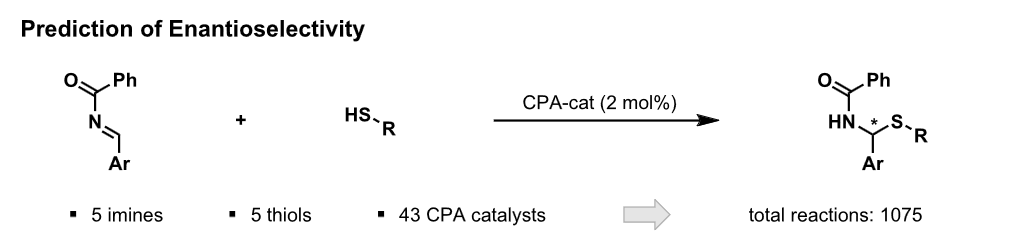
    <p style="text-align: center;">
      <b>Fig 12</b> Simplified reaction scheme for the enantioselective formation of <i>N,S</i>-acetals developed by <i>Antila et al.</i> <b><sup>3</sup></b> <b><sup>8</sup></b>
    </p>
</div>

## 4.1 Data Preparation

In [24]:
# Load data
ns_thiol_enantioselectivity_dataset: pd.DataFrame = pd.read_csv(
    os.path.join(
        os.getenv('SUP_LEARN_DATA_DIR_PATH'), 
        'raw/denmark_input_data.csv'
    )
)

# Output enantioselectivity (output column) for asymmetric N,S-acetal synthesis
ns_thiol_enantioselectivity_dataset.head()

,Catalyst,Imine,Thiol,Output
0,O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC=C2,SC1=CC=CC=C1,1.179891
1,O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC=C2,CCS,0.501759
2,O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC=C2,SC1CCCCC1,0.650584
3,O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC=C2,SC1=CC=C(OC)C=C1,1.238109
4,O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2,SC1=CC=CC=C1,1.179891


In [25]:
# Calculate Avalon fingerprints for all catalysts, imines and thiols
cpa_catalyst_ava_fpts: ExplicitBitVect = avalon_fingerprints_utils.generate_avalon_fingerprints_from_smiles(
    ns_thiol_enantioselectivity_dataset['Catalyst'],
    2048
)

imine_ava_fpts: ExplicitBitVect = avalon_fingerprints_utils.generate_avalon_fingerprints_from_smiles(
    ns_thiol_enantioselectivity_dataset['Imine'],
    1024
)

thiol_ava_fpts: ExplicitBitVect = avalon_fingerprints_utils.generate_avalon_fingerprints_from_smiles(
    ns_thiol_enantioselectivity_dataset['Thiol'],
    1024
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1075/1075 [00:00<00:00, 7622.06it/s]


In [26]:
# Concatenate Avalon fingerprints of the three N,S-Acetal synthesis reagents
# `axis=1` argument concatenates the arrays column-wise. This gives a new
# array where each row represents a molecule and each column represents a
# bit from one of the three fingerprint vectors
ns_thiol_synth_ava_fpts = np.concatenate(
    [
        cpa_catalyst_ava_fpts,
        imine_ava_fpts,
        thiol_ava_fpts
    ],
    axis=1
)

# Insert into DataFrame. Each row represents a reagents Avalon fingerprint and
# each column an individual bit
ns_thiol_synth_ava_fpts_dataset: pd.DataFrame = pd.DataFrame(
    ns_thiol_synth_ava_fpts,
    columns=['Col_A_{}'.format(bit + 1) for bit in range(ns_thiol_synth_ava_fpts.shape[1])]
)

ns_thiol_synth_ava_fpts_dataset

,Col_A_1,Col_A_2,Col_A_3,Col_A_4,Col_A_5,Col_A_6,Col_A_7,Col_A_8,Col_A_9,Col_A_10,...,Col_A_4087,Col_A_4088,Col_A_4089,Col_A_4090,Col_A_4091,Col_A_4092,Col_A_4093,Col_A_4094,Col_A_4095,Col_A_4096
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4.2 10-Fold Cross-Validation of Random Forest Regressor Model using Avalon Fingerprints of Asymmetric N,S-Acetal Synthesis Reagents and Enantioselectivity

In [27]:
# Start timer to calculate total execution time
start_time: float = time.time()

# Create a cross-validator that randomly shuffles and splits data into training and test sets
# `n_splits=10` specifies that 10 splits should be created. This is the 10-fold cross-validation
# `test_size=0.441` specifies that 44.1% of the data should be used as the test set for each split
# `randdm_state=42` specifies the random seed to ensure reproducibility
ns_thiol_enantio_yield_cross_validator: ShuffleSplit = ShuffleSplit(
    n_splits=10, 
    test_size=0.441, 
    random_state=42
)

# Define scoring metrics. 
# Metric `r2` is the coefficient of determination, which measures the proportion of variance explained by the model
# Metric `neg_mean_absolute_error` is the negative mean absolute error, measuring the average absolute errors
# between the predicted and actual values
ns_thiol_enantio_yield_scoring_metrics: List[str] = ['r2', 'neg_mean_absolute_error']

# Random Forest regressor cross-validation execution.
ns_thiol_enantio_yield_cross_validation_scores: Dict = cross_validate(
    rf_regressor, # The Random Forest regressor model to evaluate
    ns_thiol_synth_ava_fpts_dataset, # The feature matrix
    ns_thiol_enantioselectivity_dataset.Output, # The target variable (observed asymmetric N,S-acetal synthesis enantioselectivity)
    scoring=ns_thiol_enantio_yield_scoring_metrics, # The list of metrics to evaluate
    cv=ns_thiol_enantio_yield_cross_validator # The cross-validator
)

print(ns_thiol_enantio_yield_cross_validation_scores)

end_time: float = time.time()
execution_time: float = end_time - start_time
print(
    '\n Asymmetric N,S-acetal Synthesis Model Cross-Validation Execution Time: ', 
    round(execution_time/60, 2), 'min'
)

{'fit_time': array([2.18374705, 2.13135624, 2.07304835, 2.06848431, 2.06183887,
       2.0545733 , 2.04501843, 2.12066364, 2.05288625, 2.04671192]), 'score_time': array([0.02414131, 0.02306151, 0.02347517, 0.02531052, 0.02295184,
       0.02301526, 0.02479339, 0.02297664, 0.02405667, 0.02326322]), 'test_r2': array([0.90705316, 0.91493223, 0.91442174, 0.90377117, 0.89953987,
       0.90361321, 0.89020908, 0.89501053, 0.89632396, 0.91219771]), 'test_neg_mean_absolute_error': array([-0.14157402, -0.13957821, -0.14215863, -0.14813604, -0.15217813,
       -0.13714181, -0.14863539, -0.1487419 , -0.15457277, -0.14704008])}

 Asymmetric N,S-acetal Synthesis Model Cross-Validation Execution Time:  0.35 min


In [28]:
# Output mean values of R² and MAE for 10-fold cross-validation of Random Forest regressor
print(
    'Asymmetric N,S-acetal Synthesis Model Cross-Validation Cross-Validation R²: ', 
    round(np.mean(ns_thiol_enantio_yield_cross_validation_scores['test_r2']), 3), 
    '\n'
)

print(
    'Asymmetric N,S-acetal Synthesis Model Cross-Validation Mean Absolute Error: ', 
    round(
        np.mean(-ns_thiol_enantio_yield_cross_validation_scores['test_neg_mean_absolute_error']), 
        3
    )
)

Asymmetric N,S-acetal Synthesis Model Cross-Validation Cross-Validation R²:  0.904 

Asymmetric N,S-acetal Synthesis Model Cross-Validation Mean Absolute Error:  0.146


## 4.3 Split Avalon Fingerprints and Enantioselective Yield Dataset Into Training Data & Testing Data to Train & Test Random Forest Regressor Model

In [29]:
# Split data into training and test sets using `train_test_split()` function
# `ns_thiol_avalon_fpts_x_train` and `ns_thiol_avalon_fpts_x_test` are the feature 
# matrices for training and testing (Avalon fingerprints).
# `ns_thiol_enantio_y_train` and `ns_thiol_enantio_y_test` are the target 
# vectors for training and testing (N,S-thiol synthesis enantioselectivities)
(ns_thiol_avalon_fpts_x_train, ns_thiol_avalon_fpts_x_test, 
 ns_thiol_enantio_y_train, ns_thiol_enantio_y_test) = train_test_split(
    ns_thiol_synth_ava_fpts_dataset, # The feature matrix (Avalon fingerprints)
    ns_thiol_enantioselectivity_dataset.Output, # The target variable (observed N,S-thiol synthesis enantioselectivities)
    test_size=0.441, # 44.1% of the data is reserved for testing, and 65.9% is used for training
    random_state=42 # Random number generator seed
)

# Random Forest regressor model training
ns_thiol_enantio_rf_model: LGBMRegressor = rf_regressor.fit(
    ns_thiol_avalon_fpts_x_train, # Training feature matrix (Avalon fingerprints)
    ns_thiol_enantio_y_train # Training target vector (N,S-thiol synthesis enantioselectivities)
)

# Test trained Random Forest regressor model using testing feature matrix (Avalon fingerprints)
# Outputs a predicted target vector (predicted N,S-thiol synthesis enantioselectivities)
ns_thiol_enantio_rf_model_predict: np.array = ns_thiol_enantio_rf_model.predict(
    ns_thiol_avalon_fpts_x_test
)

In [30]:
# Measure model performance with Pearson correlation coefficient (R) between actual and predicted 
# N,S-thiol synthesis enantioselectivities
# Slice correlation between predicted labels and actual labels from correlation matrix
ns_thiol_enantio_predict_r: np.float64 = np.corrcoef(
    ns_thiol_enantio_y_test,
    ns_thiol_enantio_rf_model_predict
)[0, 1]

print(
    '\n Random Forest Regressor N,S-thiol Synthesis Enantioselectivities Prediction R: ', 
    round(ns_thiol_enantio_predict_r, 2)
)


 Random Forest Regressor N,S-thiol Synthesis Enantioselectivities Prediction R:  0.95


In [31]:
# Measure model performance with coefficient of determination (R²) score between actual and predicted
# N,S-thiol synthesis enantioselectivities
ns_thiol_enantio_predict_r2: float = r2_score(
    ns_thiol_enantio_y_test,
    ns_thiol_enantio_rf_model_predict
)
print(
    '\n Random Forest Regressor N,S-thiol Synthesis Enantioselectivities Prediction R²: ', 
    round(ns_thiol_enantio_predict_r2, 2)
)


 Random Forest Regressor N,S-thiol Synthesis Enantioselectivities Prediction R²:  0.91


In [32]:
# Measure model performance by calculating mean average error (MAE) between actual and predicted
# N,S-thiol synthesis enantioselectivities
ns_thiol_enantio_predict_mae: np.float64 = mean_absolute_error(
    ns_thiol_enantio_y_test,
    ns_thiol_enantio_rf_model_predict
)

print(
    '\n Random Forest Regressor N,S-thiol Synthesis Enantioselectivities Prediction MAE: ', 
    round(ns_thiol_enantio_predict_mae, 3)
)


 Random Forest Regressor N,S-thiol Synthesis Enantioselectivities Prediction MAE:  0.142


In [35]:
# Random Forest Regressor N,S-thiol Synthesis Enantioselectivities Prediction Parity Plot
sns.regplot(
    x=ns_thiol_enantio_rf_model_predict, 
    y=ns_thiol_enantio_y_test,
    line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7}
)
plt.xlabel(r"Predicted Enantioselectivities (kcal/mol) $\hat{y}$")
plt.ylabel(r"Observed Enantioselectivities (kcal/mol) $y$")
plt.title("Avalon Fingerprint N,S-thiol Synthesis Enantioselectivity Prediction Parity Plot", fontsize=10)
plt.grid(alpha=0.2)

ns_thiol_enantio_predict_label_text: str = (
    f"R = {ns_thiol_enantio_predict_r:.2f}\n"
    f"R² = {ns_thiol_enantio_predict_r2:.2f}\n"
    f"MAE (kcal/mol) = {ns_thiol_enantio_predict_mae:.2f}"
)

plt.text(0.05, 0.95, ns_thiol_enantio_predict_label_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', 
                                                         boxstyle='round,pad=0.5'))

plt.savefig(
    os.path.join(
        os.getenv('SUP_LEARN_DATA_DIR_PATH'),
        'analysis/plots/avalon-ns_thiol_enantio-parity-plot.png'
    )
)

plt.close()

<div align="center">
    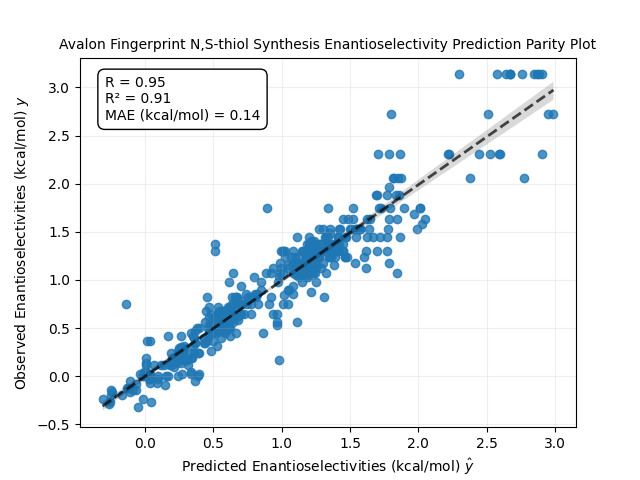
    <p style="text-align: center;">
        <b>Fig 13</b> Parity plot for Random Forest regressor N,S-thiol Synthesis Enantioselectivity prediction from Avalon fingerprints
    </p>
</div>

# 5. References

**[1]** Goshu, G.M. (2023) Avalon-fingerprints-for-machine-learning/avalon fingerprints for predictive modeling.ipynb at main · GASHAWMG/Avalon-fingerprints-for-machine-learning, *GitHub*. Available at: https://github.com/gashawmg/Avalon-fingerprints-for-machine-learning/blob/main/Avalon%20fingerprints%20for%20predictive%20modeling.ipynb (Accessed: 10 July 2024).<br><br>
**[2]** Kühnemund, M. (2020) Marius Kühnemund / FP-DM-tool · GitLab, *GitLab*. Available at: https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool (Accessed: 10 July 2024).<br><br>
**[3]** Sandfort, F. et al. (2020) ‘A structure-based platform for predicting chemical reactivity’, *Chem*, 6(6), pp. 1379–1390.<br><br>
**[4]** Ahneman, D.T. et al. (2018) ‘Predicting reaction performance in C–N cross-coupling using machine learning’, *Science*, 360(6385), pp. 186–190.<br><br>
**[5]** Sigman, M.S., Harper, K.C., Bess, E.N., and Milo, A. (2016) 'The development of multidimensional analysis tools for asymmetric catalysis and beyond', *Acc. Chem. Res.*, 49,
pp 1292–1301.<br><br>
**[6]**  Denmark, S.E., Gould, N.D., and Wolf, L.M. (2011). A systematic investigation of quaternary ammonium ions as asymmetric phase-transfer catalysts. Application of quantitative structure activity/selectivity relationships. *J. Org. Chem.*,76, pp 4337–4357.<br><br>
**[7]** Zahrt, A.F. et al. (2019) ‘Prediction of higher-selectivity catalysts by computer-driven workflow and machine learning’, *Science*, 363(6424).<br><br>
**[8]** G. K. Ingle, M. G. Mormino, L. Wojtas, J. C. Antilla, Chiral phosphoric acid-catalyzed addition of thiols to N-acyl imines: Access to chiral N,S-acetals. *Org. Lett.* 13, 4822–4825 (2011)